In [1]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc, h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from scipy.io import wavfile
np.random.seed(7)

In [12]:
# load labels
label_file = pd.read_csv('./shipsEar_AUDIOS/models_label.csv', header=None)

# mel spectrogram method

## create dataset

In [5]:
def create_melspectrogram(file_path, sampling_rate=52734, min_seconds=9, n_mels=64, hop_length=415, previus_y=[]):
  y, _ = librosa.load(file_path, sr=sampling_rate)
  y, _ = librosa.effects.trim(y)
  print(y.shape)
  for item in previus_y:
    y = np.concatenate((y, item))
  if y.shape[0] < 26367:
    return -1, y 
  frames = librosa.util.frame(y, frame_length=int(sampling_rate/2), hop_length=int(sampling_rate/2*0.2)) # 0.8 overlap
  spectrogram = librosa.feature.melspectrogram(frames[:,0], sr=sampling_rate, n_mels=n_mels,
                                                  hop_length=hop_length,n_fft=n_mels*20)
  mels = np.zeros((frames.shape[1], spectrogram.shape[0], spectrogram.shape[1]))
  mels[0, :, :] = spectrogram
  for i in range(frames.shape[1]-1):
    spectrogram1 = librosa.feature.melspectrogram(frames[:,i+1], sr=sampling_rate, n_mels=n_mels,
                                                  hop_length=hop_length,n_fft=n_mels*20)
    spectrogram = librosa.power_to_db(spectrogram1)
    mels[i+1, :, :] = spectrogram.astype(np.float32)
  return mels

In [14]:
label_file[0][0]

'10__10_07_13_marDeOnza_Sale.wav'

In [ ]:
i=0
data = create_melspectrogram('./shipsEar_AUDIOS/'+label_file[0][i])
print(data.shape)
labels = label_file[1][i]*np.ones((len(data),))
gc.collect()
for i in range(1, len(label_file)):
  features = create_melspectrogram('./shipsEar_AUDIOS/'+label_file[0][i])
  data = np.append(data, features, axis=0)
  labels = np.append(labels, label_file[1][i]*np.ones((len(features),)), axis=0)
  gc.collect()
  print(i, data.shape)

labels = labels.astype('int16')
print(data.shape, labels.shape)

(8166492,)
(1544, 64, 64)
(4325110,)
1 (2360, 64, 64)
(6402303,)
2 (3570, 64, 64)
(10940823,)
3 (5640, 64, 64)
(3164040,)
4 (6236, 64, 64)
(7526262,)
5 (7659, 64, 64)
(8607539,)
6 (9287, 64, 64)
(4054791,)
7 (10051, 64, 64)
(35995165,)
8 (16873, 64, 64)
(19747546,)
9 (20614, 64, 64)
(1593462,)
10 (20912, 64, 64)
(2304829,)
11 (21345, 64, 64)
(2828835,)
12 (21877, 64, 64)
(524654,)
13 (21972, 64, 64)
(2251809,)
14 (22395, 64, 64)
(7416895,)
15 (23797, 64, 64)
(1238495,)
16 (24027, 64, 64)
(1618488,)
17 (24329, 64, 64)
(8627243,)
18 (25961, 64, 64)
(4968053,)
19 (26899, 64, 64)
(2336252,)
20 (27338, 64, 64)
(3377713,)
21 (27974, 64, 64)
(11411526,)
22 (30134, 64, 64)
(1973090,)
23 (30504, 64, 64)
(6522975,)
24 (31737, 64, 64)
(5138868,)
25 (32707, 64, 64)
(5367098,)
26 (33720, 64, 64)
(2319116,)
27 (34155, 64, 64)
(5638341,)
28 (35220, 64, 64)
(3900097,)
29 (35955, 64, 64)
(2329834,)
30 (36392, 64, 64)
(2789958,)
31 (36917, 64, 64)
(3067493,)
32 (37494, 64, 64)
(2716922,)
33 (38005, 64, 

In [ ]:
del features
gc.collect()

In [ ]:
hf = h5py.File('./data.h5', 'w')
hf.create_dataset('data', data=data)
hf.create_dataset('labels', data=labels)
hf.close()

In [16]:
f = h5py.File('./data.h5', "r")
data = np.array(f['data'])
labels = np.array(f['labels'])
f.close()

In [17]:
data.shape

(112954, 64, 64)

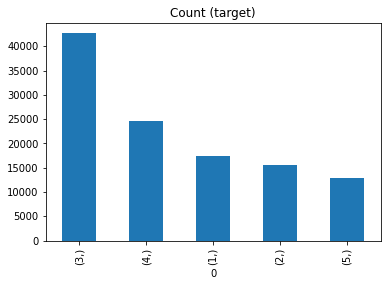

In [19]:
target_count = pd.DataFrame(labels).value_counts()
target_count.plot(kind='bar', title='Count (target)')
plt.show()

In [20]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=42)
del data, labels
# compute class weights
unq_lab = np.unique(train_y)
class_weights = compute_class_weight('balanced', unq_lab, train_y.tolist())
weights = dict()
for i in range(unq_lab.shape[0]):
    weights[i] = class_weights[i]

enc = OneHotEncoder(sparse=False)
train_y_encoded = enc.fit_transform(train_y.reshape(-1,1))
test_y_encoded = enc.transform(test_y.reshape(-1,1))

sc = MinMaxScaler()
for i in range(train_x.shape[0]):
  sc.partial_fit(train_x[i])
for i in range(train_x.shape[0]):
  train_x[i] = sc.transform(train_x[i])
for i in range(test_x.shape[0]):
  test_x[i] = sc.transform(test_x[i])
print('normalization passed')

normalization passed


In [21]:
gc.collect()

5626

## training and evaluation

In [22]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [23]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [24]:
num_class = 5
batch_size=128
epochs = 30

In [25]:
inp = Input((64,64,1))
l = Conv2D(128, kernel_size=(7,7), strides=(2,2), padding='same')(inp)
l = MaxPooling2D(pool_size=2)(l)
l = Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same')(l)
l = MaxPooling2D(pool_size=2)(l)
l = Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(l)
l = Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(l)
l = Flatten()(l)
l = Dropout(0.3)(l)
l = Dense(512, activation='relu')(l)
out = Dense(num_class, activation='softmax')(l)
model = Model(inp, out)

model.compile(optimizer= optimizers.Adam(lr=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy', f1_metric])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)
train_x.shape, test_x.shape

((90363, 64, 64, 1), (22591, 64, 64, 1))

In [27]:
history = model.fit(train_x, train_y_encoded, epochs=epochs, batch_size=batch_size,
                    shuffle=True, validation_data=(test_x, test_y_encoded))

Epoch 1/30
706/706 [==============================] - 63s 27ms/step - loss: 1.3856 - accuracy: 0.4066 - f1_metric: 0.1047 - val_loss: 0.9265 - val_accuracy: 0.5973 - val_f1_metric: 0.5651
Epoch 2/30
706/706 [==============================] - 18s 26ms/step - loss: 0.9091 - accuracy: 0.6097 - f1_metric: 0.5624 - val_loss: 0.7556 - val_accuracy: 0.6711 - val_f1_metric: 0.6516
Epoch 3/30
706/706 [==============================] - 18s 26ms/step - loss: 0.7501 - accuracy: 0.6806 - f1_metric: 0.6485 - val_loss: 0.6021 - val_accuracy: 0.7504 - val_f1_metric: 0.7249
Epoch 4/30
706/706 [==============================] - 19s 27ms/step - loss: 0.6233 - accuracy: 0.7336 - f1_metric: 0.7169 - val_loss: 0.5222 - val_accuracy: 0.7927 - val_f1_metric: 0.7790
Epoch 5/30
706/706 [==============================] - 19s 27ms/step - loss: 0.5402 - accuracy: 0.7778 - f1_metric: 0.7666 - val_loss: 0.4854 - val_accuracy: 0.8114 - val_f1_metric: 0.8047
Epoch 6/30
706/706 [==============================] - 19s 27

In [29]:
model.save('./best_model.h5')
#model = load_model('./best_model.h5')

In [28]:
pred = np.argmax(model.predict(test_x), axis=1)
test_yy = np.argmax(test_y_encoded, axis=1)
print('Classification Report')
print(classification_report(test_yy, pred, digits=4))

Classification Report
              precision    recall  f1-score   support

           0     0.9891    0.9872    0.9881      3505
           1     0.9731    0.9909    0.9819      3061
           2     0.9967    0.9898    0.9933      8556
           3     0.9969    0.9973    0.9971      4898
           4     0.9942    0.9973    0.9957      2571

    accuracy                         0.9920     22591
   macro avg     0.9900    0.9925    0.9912     22591
weighted avg     0.9921    0.9920    0.9920     22591



In [30]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1_metric', 'val_loss', 'val_accuracy', 'val_f1_metric'])


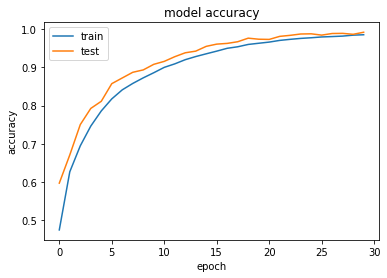

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

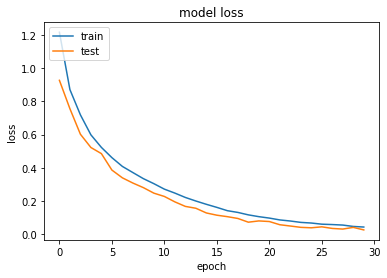

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
print(accuracy_score(test_yy, pred))

0.9920322252224337


In [35]:
pd.DataFrame(test_yy).to_csv('./test_y.csv')

In [36]:
pd.DataFrame(pred).to_csv('./y_pred.csv')

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(test_yy, pred)

array([[3460,   34,   10,    1,    0],
       [   5, 3033,   14,    0,    9],
       [  22,   48, 8469,   11,    6],
       [  11,    0,    2, 4885,    0],
       [   0,    2,    2,    3, 2564]])